In [255]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
import os
from tqdm.notebook import tqdm

In [256]:
np.random.seed(42)

NAME = 'assignment4'
DATA_PATH = f'data/{NAME}'
MEDIA_PATH = f'media/{NAME}'
[os.makedirs(path, exist_ok=True) for path in [DATA_PATH, MEDIA_PATH]]
print('Setup complete')

Setup complete


# Ising Model

In [257]:
# Declare parameters
#---------------------------------------
n_steps = 10001
nx = 40
T = 1
k = 0.5

# Create initial grid
grid_0 = np.zeros((nx + 2, nx + 2))
grid_0[1:-1, 1:-1] = np.random.choice([-1, 1], (nx,nx))


def Ising_model(J):
    # Create grid
    grid = grid_0.copy()
    
    # Create list to store Magnetization modulus
    M = np.zeros(n_steps + 1)
    
    for step in range(n_steps):
        
        # Randomly choose lattice site 
        M[step:] += abs(np.sum(grid))
        i, j = np.random.randint(1, 41, 2)

        # Hamiltonian
        H = J*(grid[i - 1, j] + grid[i + 1, j] + grid[i, j - 1] + grid[i, j + 1])
        
        # Probability
        P = np.exp(-H*2*grid[i, j])

        # Update grid
        if P > np.random.sample():
            grid[i, j] = -grid[i, j]

    # Create figures        
    fig = plt.figure(facecolor='w', figsize=(12,4), dpi=80)
 
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax.plot( M/(np.arange(1,n_steps+2)*(nx*nx)) , 'brown')
    ax.grid(b=True, which='major', c='k', alpha=0.2)
    ax.set_xlabel('n')
    ax.set_ylabel('<|M|>')
    ax.set_title('Magnetization modulus for J = %d' % J)
    
    ax = plt.subplot2grid((1, 3), (0, 2))
    ax.matshow(grid[1:-1, 1:-1], cmap = 'hot')
    ax.set_title('n = %i' % n_steps)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    

# Cellular Pots model

In [258]:
def kronecker_delta(i, j):
    return np.equal(i, j).astype(int)

def Cellular_Potts_model(
        J,                  # interaction strength matrix
        A,                  # equilibrium areas (should be -1 for the fluid)
        n_MCS = 2,          # number of Monte Carlo steps
        T = 1,              # temperature
        n_cells = 240,      # number of cells
        n_types = 3,        # number of cell types
        nx = 100,           # size of the grid side
        k = 1,              # "Boltzmann constant"
        lam_vol = 1,         # lambda volume parameter
        return_grids_at = None # list of time steps to return the grid
    ):

    assert J.shape == (n_types, n_types), f"Received: {J.shape}, Expected: {(n_types, n_types)}"
    assert A.shape == (n_types, ) and A[0] == -1
    assert T > 0

    # Monte Carlo step as defined in the paper
    MCS = 16 * nx**2

    # Type-recognizing function
    celltype = lambda sigma : np.mod(sigma, n_types)

    # Create grid of cell ids with continuous boundaries
    # NOTE: This is a hardcoded part working for this specific no. of cells and grid size
    grid = np.zeros((nx, nx), dtype=int)
    assign_order = np.random.permutation(n_cells)
    ysteps = np.linspace(0, 100, 21, dtype=int)

    for (i, y) in enumerate(ysteps[:-1]):
        xsteps = sorted(np.random.choice(range(1, 99), 11, replace=False))
        xsteps = np.insert(xsteps, 0, 0)
        xsteps = np.append(xsteps, 100)

        for (j, x) in enumerate(xsteps[:-1]):
            grid[y:ysteps[i+1], x:xsteps[j+1]] = assign_order[i*12 + j]

    # Store cell areas
    _, areas = np.unique(grid, return_counts=True)

    grids = []

    # Neighborhoods
    von_neumann_neighbourhood = np.array([[-1, 0], [0, -1], [0, 1], [1, 0]])
    moore_neighborhood = np.array([(-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0)])
    
    for n in tqdm(range(n_MCS), unit='MCS', desc='Simulating', leave=False):
        for step in range(MCS):
            
            # Calculate magnetization
            # M[step:] += abs(np.sum(grid))

            # Randomly choose lattice site 
            i, j = np.random.randint(0, nx, 2)
            sigma = grid[i,j]
            tau = celltype(sigma)

            # Randomly choose a neighbour
            ip, jp = von_neumann_neighbourhood[np.random.randint(4)]
            iprime, jprime = (i + ip) % nx, (j + jp) % nx

            sigma_prime = grid[iprime, jprime]
            tau_prime = celltype(sigma_prime)

            # Change in volumetric energy
            a_sigma = areas[sigma]
            a_sigma_prime = areas[sigma_prime]

            A_sigma = A[tau]
            A_sigma_prime = A[tau_prime]

            delta_Hvol = -1
            if sigma == sigma_prime:
                delta_Hvol = 0
            elif (sigma != 0 and sigma_prime != 0):
                delta_Hvol = lam_vol * (((a_sigma - 1 - A_sigma)**2 + (a_sigma_prime + 1 - A_sigma_prime)**2) -
                                    ((a_sigma - A_sigma)**2 + (a_sigma_prime - A_sigma_prime)**2))
            elif (sigma == 0):
                delta_Hvol = lam_vol * ((a_sigma_prime + 1 - A_sigma_prime)**2 -
                                    (a_sigma_prime - A_sigma_prime)**2)
            elif (sigma_prime == 0):
                delta_Hvol = lam_vol * ((a_sigma - 1 - A_sigma)**2 -
                                    (a_sigma - A_sigma)**2)
            
            # Change in bond energy
            x = (i + moore_neighborhood[:,0]) % nx
            y = (j + moore_neighborhood[:,1]) % nx
            sum_prime = np.sum(J[tau_prime, celltype(grid[x, y])] * (1 - kronecker_delta(sigma_prime, grid[x, y])))
            sum_orig = np.sum(J[tau, celltype(grid[x, y])] * (1 - kronecker_delta(sigma, grid[x, y])))
            delta_Hbond = sum_prime - sum_orig
            
            # Total change
            H = delta_Hvol + delta_Hbond
            
            P = np.exp(-H/(k*T))

            # Update grid
            if H <= 0 or P > np.random.sample():
                grid[i, j] = grid[iprime, jprime]
                areas[sigma] -= 1
                areas[sigma_prime] += 1
            
            if return_grids_at is not None and n*MCS + step in return_grids_at:
                grids.append(grid.copy())

    if return_grids_at is not None:
        return grids
    else:
        return grid

In [259]:
def plot_cellular_potts(ax, grid, n_types, n_MCS):
    # Type-recognizing function
    celltype = lambda sigma : (sigma % n_types)

    ax.grid()

    # Yeah it will only work for two cell types + surrounding fluid
    celltype_grid = celltype(grid)
    cmap = ListedColormap(['cyan', 'dimgray', 'gold'])
    ax.matshow(celltype_grid, cmap=cmap)

    # Draw cell boundaries
    for (i, _) in enumerate(grid):
        for (j, _) in enumerate(grid[i,:-1]):
            # Vertical checking
            if (i + 1 != grid.shape[0] and grid[i, j] != grid[i+1, j]):
                plt.plot([j-0.5, j+0.5], [i+0.5, i+0.5], c="black", lw=1.5)

            # Horizontal checking
            if (j + 1 != grid[0].shape[0] and grid[i, j] != grid[i, j+1]):
                plt.plot([j+0.5, j+0.5], [i-0.5, i+0.5], c="black", lw=1.5)

    # Set the title
    nsteps = 16 * n_MCS * grid.shape[0]**2
    ax.set_title('n = %i' % nsteps)

    # Turn off the axis
    ax.axis('off')

    medium_patch = mpatches.Patch(color='cyan', label='Medium')
    T1_patch = mpatches.Patch(color='dimgray', label='T_1')
    T2_patch = mpatches.Patch(color='gold', label='T_2')
    ax.legend(handles=[medium_patch, T1_patch, T2_patch], loc='upper right')

def animate_grids(grids, ts, fps):
    pbar = tqdm(total=len(grids), desc='Rendering', unit='frames')
    fig, ax = plt.subplots()

    def update(i):
        ax.clear()
        plot_cellular_potts(ax, grids[i], ntypes, (ts[i]+1)/MCS)
        pbar.update(1)

    ani = animation.FuncAnimation(fig, update, frames=len(grids), interval=1000//fps)

    return ani

Parameterization utility functions from paper or for seperate exploration to run cellular pots model

In [260]:
def gen_A_paper(ntypes=3):
    '''
    Based on section II.A2. and section II.B1. in the paper
    '''
    A = np.zeros(ntypes)
    A[0] = -1
    A[1:] = 40
    return A

def gen_J_paper():
    '''
    Based on section III.A2. in the paper. J rows in order corresponding to surrounding medium M,
    low surface energy 'dark cells' d, high surface energy 'light cells' l.
    '''
    J_MM = 0
    J_ll = 10
    J_dd = 8
    J_ld = 6
    J_lM = 12
    J_dM = 12

    J = np.array([
        [J_MM, J_dM, J_lM,],
        [J_dM, J_dd, J_ld,],
        [J_lM, J_ld, J_ll,],
    ])

    return J

Paper config

Simulating: 0MCS [00:00, ?MCS/s]

Simulating:   0%|          | 0/2 [00:00<?, ?MCS/s]

KeyboardInterrupt: 

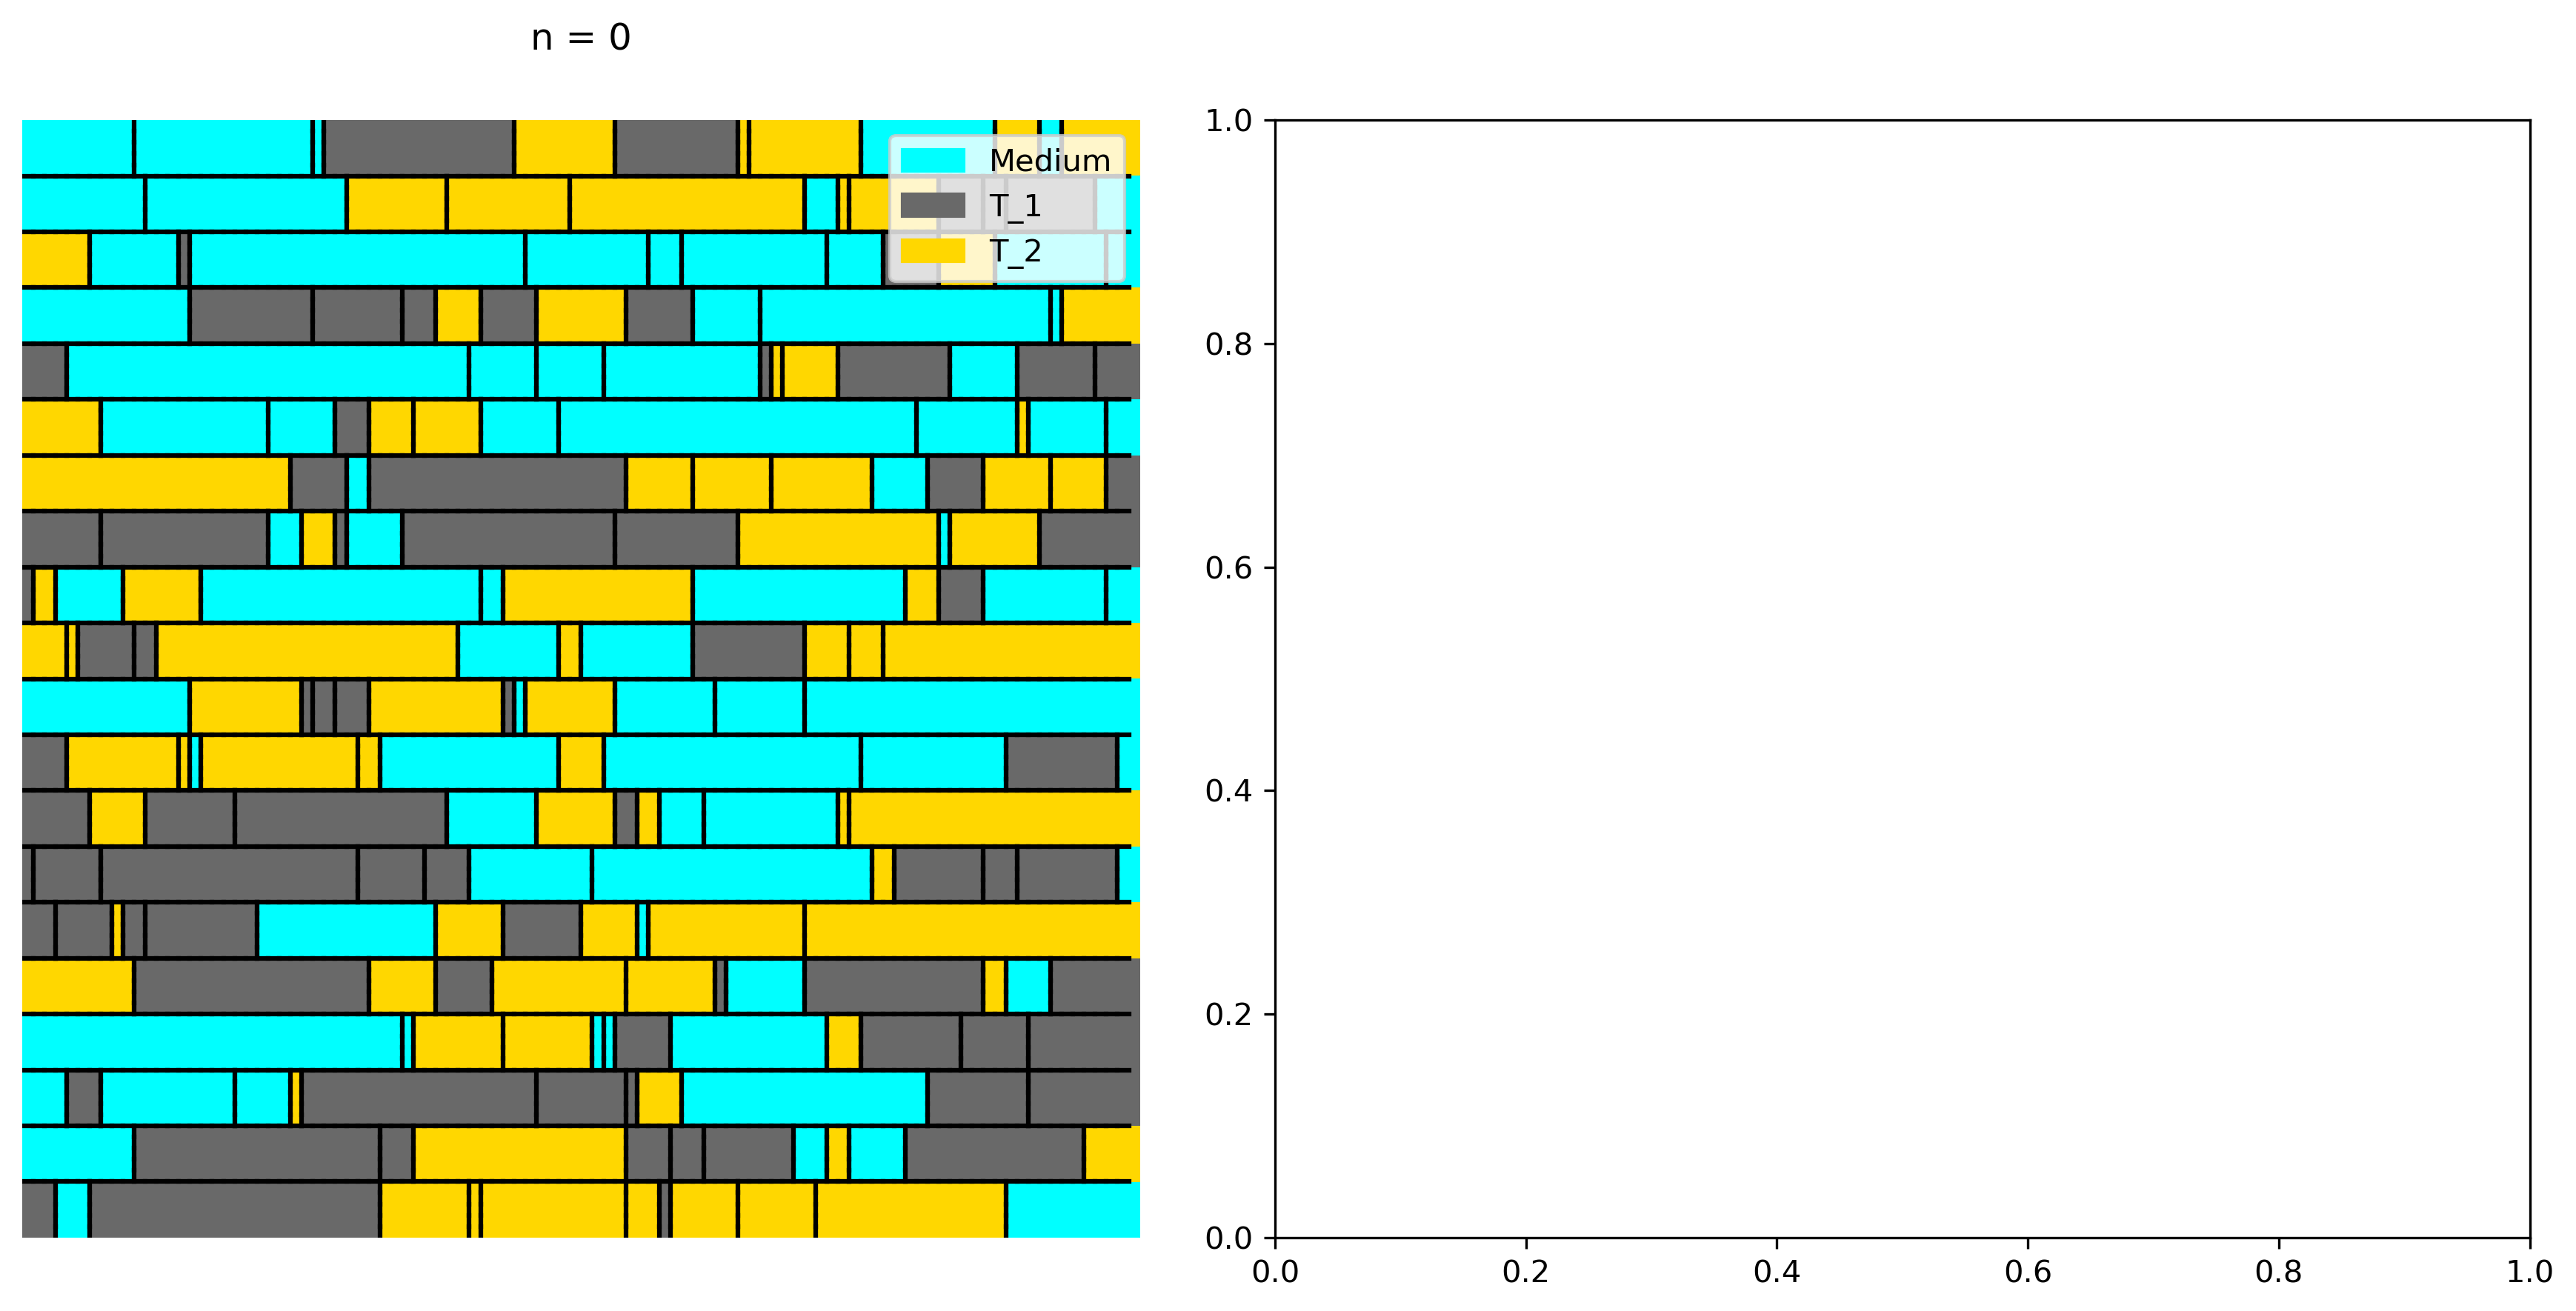

In [261]:
## Parameters
n_types = 3
A = gen_A_paper(n_types)
nx = 100
n_cells = 20
T = 10
lam_vol = 1
J = gen_J_paper()
n_MCSs = [0, 2]
k = 1

np.random.seed(42)

fig = plt.figure(facecolor='w', figsize=(12,6), dpi=300, layout='tight')
for i, n_MCS in enumerate(n_MCSs):
    ax = plt.subplot2grid((1, len(n_MCSs)), (0, i))
    cell_ids = Cellular_Potts_model(J, A, n_MCS, T)
    plot_cellular_potts(ax, cell_ids, ntypes, n_MCS)

Simulating:   0%|          | 0/1 [00:00<?, ?MCS/s]

Rendering:   0%|          | 0/301 [00:00<?, ?frames/s]

KeyboardInterrupt: 

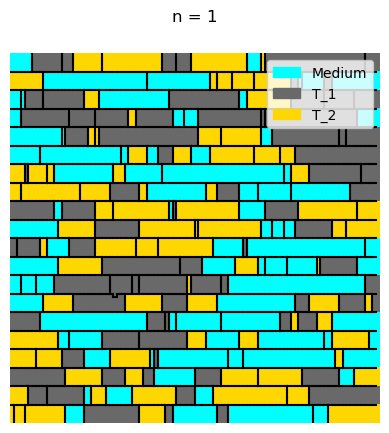

In [ ]:
n_MCS = 100
MCS = 16*nx**2
frames = 300
fps = 60
ts = np.arange(0, n_MCS*MCS, n_MCS*MCS//frames)
grids = Cellular_Potts_model(J, A, n_MCS=n_MCS, T=T, return_grids_at=ts)
anim = animate_grids(grids, ts, fps)
anim.save(f'animated_potts_{n_MCS}MCS_{frames}_frames_{fps}_fps.gif', writer='ffmpeg')

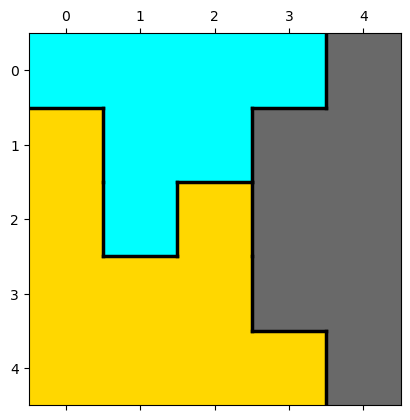

In [ ]:
np.random.seed(42)

xx = np.array([
    [0, 0, 0, 0, 1], 
    [2, 0, 0, 1, 1], 
    [2, 0, 2, 1, 1], 
    [2, 2, 2, 1, 1], 
    [2, 2, 2, 2, 1], 
])

cmap = ListedColormap(['cyan', 'dimgray', 'gold'])
plt.matshow(xx, cmap=cmap)
# plt.axis('off')

NX = 5

for (i, y) in enumerate(xx):
    for (j, x) in enumerate(xx[i,:-1]):
        # Vertical checking
        if (i + 1 != xx.shape[0] and xx[i, j] != xx[i+1, j]):
            plt.plot([j-0.5, j+0.5], [i+0.5, i+0.5], c="black", lw=2.5)

        # Horizontal checking
        if (j + 1 != xx[0].shape[0] and xx[i, j] != xx[i, j+1]):
            plt.plot([j+0.5, j+0.5], [i-0.5, i+0.5], c="black", lw=2.5)

plt.show()